In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes
import copy,os

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

import seaborn as sns
sns.set()

In [3]:
df_sales = pd.read_csv('../../data/rdc_sales_1320_replenishment_V1_filled.csv')
df_sl = df_sales.set_index('row')
df_sl.rename(columns=lambda x: (dt.datetime(2016,1,1) + dt.timedelta(days=int(x)-730)).date(), inplace=True)
df_sl = df_sl.reset_index()

In [4]:
data_start_date = df_sl.columns[1]
data_end_date = df_sl.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2016-01-01 to 2018-08-31


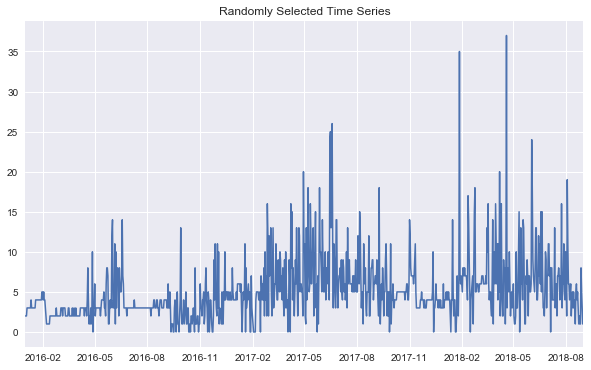

In [5]:

plt.figure(figsize=(10,6))

pd.Series(df_sl.iloc[20016,1:]).astype(np.float64).plot(linewidth=1.5)

plt.title('Randomly Selected Time Series');
    
# plot_random_series(df_sl, 1)

In [6]:
from datetime import timedelta

pred_steps = 30
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

In [7]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

In [8]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2016-01-01 00:00:00 - 2018-07-02 00:00:00
Train prediction: 2018-07-03 00:00:00 - 2018-08-01 00:00:00 

Val encoding: 2016-01-31 00:00:00 - 2018-08-01 00:00:00
Val prediction: 2018-08-02 00:00:00 - 2018-08-31 00:00:00

Encoding interval: 914
Prediction interval: 30


In [8]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df_sl.columns[1:]]),
                          data=[i for i in range(len(df_sl.columns[1:]))])

series_array = df_sl[df_sl.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
#     series_array = np.nan_to_num(series_array) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
#     series_array = np.nan_to_num(series_array) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [9]:
first_n_samples = 20000
batch_size = 2**11
epochs = 50

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# lagged target series for teacher forcing
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

In [18]:

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 40
# length of output signals
output_seq_len = 30
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 1
# num of output signals
output_dim = 1
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

def build_graph():
    
    tf.reset_default_graph()
    
    global_step = tf.Variable(
                  initial_value=0,
                  name="global_step",
                  trainable=False,
                  collections=[tf.GraphKeys.GLOBAL_STEP, tf.GraphKeys.GLOBAL_VARIABLES])
    weights = {
        'out': tf.get_variable('Weights_out', \
                               shape = [hidden_dim, output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.truncated_normal_initializer()),
    }
    biases = {
        'out': tf.get_variable('Biases_out', \
                               shape = [output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.constant_initializer(0.)),
    }                                          
    with tf.variable_scope('Seq2seq'):
        # Encoder: inputs
        enc_inp = [
            tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
               for t in range(input_seq_len)
        ]

        # Decoder: target outputs
        target_seq = [
            tf.placeholder(tf.float32, shape=(None, output_dim), name="y".format(t))
              for t in range(output_seq_len)
        ]

        # Give a "GO" token to the decoder. 
        # If dec_inp are fed into decoder as inputs, this is 'guided' training; otherwise only the 
        # first element will be fed as decoder input which is then 'un-guided'
        dec_inp = [ tf.zeros_like(target_seq[0], dtype=tf.float32, name="GO") ] + target_seq[:-1]

        with tf.variable_scope('LSTMCell'): 
            cells = []
            for i in range(num_stacked_layers):
                with tf.variable_scope('RNN_{}'.format(i)):
                    cells.append(tf.contrib.rnn.LSTMCell(hidden_dim))
            cell = tf.contrib.rnn.MultiRNNCell(cells)
         
        def _rnn_decoder(decoder_inputs,
                        initial_state,
                        cell,
                        scope=None):

            with variable_scope.variable_scope(scope or "rnn_decoder"):
                state = initial_state
                outputs = []
                prev = None
                for i, inp in enumerate(decoder_inputs):
                    if i > 0:
                        variable_scope.get_variable_scope().reuse_variables()
                    output, state = cell(inp, state)
                    outputs.append(output)
            return outputs, state

        def _basic_rnn_seq2seq(encoder_inputs,
                              decoder_inputs,
                              cell,
                              dtype=dtypes.float32,
                              scope=None):

            with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
                enc_cell = copy.deepcopy(cell)
                _, enc_state = rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
                return _rnn_decoder(decoder_inputs, enc_state, cell)
    
        dec_outputs, dec_memory = _basic_rnn_seq2seq(
            enc_inp, 
            dec_inp, 
            cell
        )

        reshaped_outputs = [tf.matmul(i, weights['out']) + biases['out'] for i in dec_outputs]
        
    # Training loss and optimizer
    with tf.variable_scope('Loss'):
        # L2 loss
        output_loss = 0
        for _y, _Y in zip(reshaped_outputs, target_seq):
            output_loss += tf.reduce_mean(tf.pow(_y - _Y, 2))

        # L2 regularization for weights and biases
        reg_loss = 0
        for tf_var in tf.trainable_variables():
            if 'Biases_' in tf_var.name or 'Weights_' in tf_var.name:
                reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

        loss = output_loss + lambda_l2_reg * reg_loss
        print(1)

    with tf.variable_scope('Optimizer'):
        optimizer = tf.contrib.layers.optimize_loss(
                loss=loss,
                learning_rate=learning_rate,
                global_step=global_step,
                optimizer='Adam',
                clip_gradients=GRADIENT_CLIPPING)
        print(2)
        
    saver = tf.train.Saver
    
    return dict(
        enc_inp = enc_inp, 
        target_seq = target_seq, 
        train_op = optimizer, 
        loss=loss,
        saver = saver, 
        reshaped_outputs = reshaped_outputs,
        )

In [19]:
total_iteractions = 100
batch_size = 200
KEEP_RATE = 0.5
train_losses = []
val_losses = []

tf.reset_default_graph()
rnn_model = build_graph()
print('Build done.')
saver = tf.train.Saver()

1
2
Build done.


In [20]:
init = tf.global_variables_initializer()
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:

    sess.run(init)
    
    for i in range(total_iteractions):
        loss = 0
        for bs in range(first_n_samples//batch_size):
            idx = np.random.randint(first_n_samples//batch_size) * batch_size
            feed_dict = {rnn_model['enc_inp'][t]: 
                         encoder_input_data[idx:idx+batch_size,t+914-input_seq_len,:] for t in range(input_seq_len)}
            feed_dict.update({rnn_model['target_seq'][t]: 
                              decoder_target_data[idx:idx+batch_size,t,:] for t in range(output_seq_len)})
            _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
            loss += loss_t*batch_size
        print(loss/first_n_samples)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./../logs/temp', 'univariate_ts_model0'))
        
print("Checkpoint saved at: ", save_path)

7.906538899242878
4.508945012092591
5.432448804974556
4.478440845608711
5.0951364195346835
4.636205283999443
4.997732587754727
4.839625854492187
4.406311686038971
4.600690131783486
4.22312475502491
4.229267410039902
4.4071972005814315
4.6438541507720945
4.54847475156188
4.075903425440192
4.356618999838829
4.466100761964917
4.445778044238686
3.777721424810588
3.8807689099013807
3.8041210978850724
4.07726764574647
3.6541662396490575
3.9740265927091243
3.690218687467277
3.3026954755187035
4.3224860834702845
4.53798336148262
3.833935160562396
4.113726317547262
3.6319748938456176
4.195043932087719
4.136898000314832
4.086175908856094
4.078524855449796
4.265624214559794
3.9652421102300286
3.6810023433715107
3.8012329430878165
3.511944389566779
3.6843489822000266
3.9344280224665997
4.1623765447363255
3.814877622127533
4.043699924200773
3.642052710056305
4.171045744456351
3.7915954333543778
3.6938341012224556
3.8092141986265777
3.7245631517097353
3.9145026394724844
4.0210058500617745
3.21920886